c:\Python3.12\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,209 (430.50 KB)

 Trainable params: 109,761 (428.75 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/50
1199/1199 ━━━━━━━━━━━━━━━━━━━━ 0s 633ms/step - accuracy: 0.8106 - loss: 0.4009
Epoch 1: val_loss improved from inf to 0.35527, saving model to best_model.h5


1199/1199 ━━━━━━━━━━━━━━━━━━━━ 790s 657ms/step - accuracy: 0.8106 - loss: 0.4009 - val_accuracy: 0.8295 - val_loss: 0.3553
Epoch 2/50
1199/1199 ━━━━━━━━━━━━━━━━━━━━ 0s 611ms/step - accuracy: 0.8355 - loss: 0.3501
Epoch 2: val_loss did not improve from 0.35527
1199/1199 ━━━━━━━━━━━━━━━━━━━━ 762s 635ms/step - accuracy: 0.8355 - loss: 0.3501 - val_accuracy: 0.8215 - val_loss: 0.3679
Epoch 3/50
1199/1199 ━━━━━━━━━━━━━━━━━━━━ 0s 615ms/step - accuracy: 0.8403 - loss: 0.3443
Epoch 3: val_loss did not improve from 0.35527
1199/1199 ━━━━━━━━━━━━━━━━━━━━ 765s 638ms/step - accuracy: 0.8403 - loss: 0.3443 - val_accuracy: 0.8287 - val_loss: 0.3553
Epoch 4/50
1199/1199 ━━━━━━━━━━━━━━━━━━━━ 0s 612ms/step - accuracy: 0.8398 - loss: 0.3406
Epoch 4: val_loss improved from 0.35527 to 0.35388, saving model to best_model.h5


1199/1199 ━━━━━━━━━━━━━━━━━━━━ 761s 635ms/step - accuracy: 0.8398 - loss: 0.3406 - val_accuracy: 0.8372 - val_loss: 0.3539
Epoch 5/50
1199/1199 ━━━━━━━━━━━━━━━━━━━━ 0s 608ms/step - accuracy: 0.8429 - loss: 0.3370
Epoch 5: val_loss improved from 0.35388 to 0.34977, saving model to best_model.h5


1199/1199 ━━━━━━━━━━━━━━━━━━━━ 757s 632ms/step - accuracy: 0.8429 - loss: 0.3370 - val_accuracy: 0.8359 - val_loss: 0.3498
Epoch 6/50
1199/1199 ━━━━━━━━━━━━━━━━━━━━ 0s 609ms/step - accuracy: 0.8454 - loss: 0.3343
Epoch 6: val_loss improved from 0.34977 to 0.33233, saving model to best_model.h5


1199/1199 ━━━━━━━━━━━━━━━━━━━━ 760s 634ms/step - accuracy: 0.8454 - loss: 0.3343 - val_accuracy: 0.8456 - val_loss: 0.3323
Epoch 7/50
1199/1199 ━━━━━━━━━━━━━━━━━━━━ 0s 608ms/step - accuracy: 0.8440 - loss: 0.3328
Epoch 7: val_loss improved from 0.33233 to 0.32595, saving model to best_model.h5


1199/1199 ━━━━━━━━━━━━━━━━━━━━ 758s 632ms/step - accuracy: 0.8440 - loss: 0.3328 - val_accuracy: 0.8472 - val_loss: 0.3259
Epoch 8/50
1199/1199 ━━━━━━━━━━━━━━━━━━━━ 0s 613ms/step - accuracy: 0.8476 - loss: 0.3292
Epoch 8: val_loss improved from 0.32595 to 0.32552, saving model to best_model.h5


1199/1199 ━━━━━━━━━━━━━━━━━━━━ 769s 641ms/step - accuracy: 0.8476 - loss: 0.3292 - val_accuracy: 0.8482 - val_loss: 0.3255
Epoch 9/50
1199/1199 ━━━━━━━━━━━━━━━━━━━━ 0s 639ms/step - accuracy: 0.8475 - loss: 0.3300
Epoch 9: val_loss did not improve from 0.32552
1199/1199 ━━━━━━━━━━━━━━━━━━━━ 795s 662ms/step - accuracy: 0.8475 - loss: 0.3300 - val_accuracy: 0.8201 - val_loss: 0.3842
Epoch 10/50
1199/1199 ━━━━━━━━━━━━━━━━━━━━ 0s 611ms/step - accuracy: 0.8477 - loss: 0.3271
Epoch 10: val_loss improved from 0.32552 to 0.32526, saving model to best_model.h5


1199/1199 ━━━━━━━━━━━━━━━━━━━━ 761s 634ms/step - accuracy: 0.8477 - loss: 0.3271 - val_accuracy: 0.8499 - val_loss: 0.3253
Epoch 11/50
1199/1199 ━━━━━━━━━━━━━━━━━━━━ 0s 609ms/step - accuracy: 0.8493 - loss: 0.3234
Epoch 11: val_loss improved from 0.32526 to 0.31540, saving model to best_model.h5


1199/1199 ━━━━━━━━━━━━━━━━━━━━ 758s 632ms/step - accuracy: 0.8493 - loss: 0.3234 - val_accuracy: 0.8468 - val_loss: 0.3154
Epoch 12/50
1199/1199 ━━━━━━━━━━━━━━━━━━━━ 0s 609ms/step - accuracy: 0.8493 - loss: 0.3199
Epoch 12: val_loss did not improve from 0.31540
1199/1199 ━━━━━━━━━━━━━━━━━━━━ 759s 633ms/step - accuracy: 0.8493 - loss: 0.3199 - val_accuracy: 0.8399 - val_loss: 0.3482
Epoch 13/50
1199/1199 ━━━━━━━━━━━━━━━━━━━━ 0s 613ms/step - accuracy: 0.8509 - loss: 0.3189
Epoch 13: val_loss did not improve from 0.31540
1199/1199 ━━━━━━━━━━━━━━━━━━━━ 763s 636ms/step - accuracy: 0.8509 - loss: 0.3189 - val_accuracy: 0.8376 - val_loss: 0.3392
Epoch 14/50
1199/1199 ━━━━━━━━━━━━━━━━━━━━ 0s 660ms/step - accuracy: 0.8509 - loss: 0.3211
Epoch 14: val_loss improved from 0.31540 to 0.31399, saving model to best_model.h5


1199/1199 ━━━━━━━━━━━━━━━━━━━━ 819s 683ms/step - accuracy: 0.8509 - loss: 0.3211 - val_accuracy: 0.8503 - val_loss: 0.3140
Epoch 15/50
1199/1199 ━━━━━━━━━━━━━━━━━━━━ 0s 611ms/step - accuracy: 0.8520 - loss: 0.3167
Epoch 15: val_loss did not improve from 0.31399
1199/1199 ━━━━━━━━━━━━━━━━━━━━ 761s 634ms/step - accuracy: 0.8520 - loss: 0.3167 - val_accuracy: 0.8473 - val_loss: 0.3288
Epoch 16/50
1199/1199 ━━━━━━━━━━━━━━━━━━━━ 0s 612ms/step - accuracy: 0.8512 - loss: 0.3151
Epoch 16: val_loss did not improve from 0.31399
1199/1199 ━━━━━━━━━━━━━━━━━━━━ 762s 636ms/step - accuracy: 0.8512 - loss: 0.3151 - val_accuracy: 0.8471 - val_loss: 0.3157
Epoch 17/50
1199/1199 ━━━━━━━━━━━━━━━━━━━━ 0s 633ms/step - accuracy: 0.8519 - loss: 0.3166
Epoch 17: val_loss did not improve from 0.31399
1199/1199 ━━━━━━━━━━━━━━━━━━━━ 793s 661ms/step - accuracy: 0.8519 - loss: 0.3166 - val_accuracy: 0.8484 - val_loss: 0.3175
Epoch 18/50
1199/1199 ━━━━━━━━━━━━━━━━━━━━ 0s 628ms/step - accuracy: 0.8548 - loss: 0.3145


1199/1199 ━━━━━━━━━━━━━━━━━━━━ 762s 636ms/step - accuracy: 0.8557 - loss: 0.3092 - val_accuracy: 0.8506 - val_loss: 0.3109
Epoch 22/50
1199/1199 ━━━━━━━━━━━━━━━━━━━━ 0s 662ms/step - accuracy: 0.8547 - loss: 0.3101
Epoch 22: val_loss did not improve from 0.31089
1199/1199 ━━━━━━━━━━━━━━━━━━━━ 821s 685ms/step - accuracy: 0.8547 - loss: 0.3101 - val_accuracy: 0.8350 - val_loss: 0.3542
Epoch 23/50
1199/1199 ━━━━━━━━━━━━━━━━━━━━ 0s 629ms/step - accuracy: 0.8570 - loss: 0.3064
Epoch 23: val_loss did not improve from 0.31089
1199/1199 ━━━━━━━━━━━━━━━━━━━━ 782s 652ms/step - accuracy: 0.8570 - loss: 0.3064 - val_accuracy: 0.8404 - val_loss: 0.3632
Epoch 24/50
1199/1199 ━━━━━━━━━━━━━━━━━━━━ 0s 605ms/step - accuracy: 0.8586 - loss: 0.3031
Epoch 24: val_loss did not improve from 0.31089
1199/1199 ━━━━━━━━━━━━━━━━━━━━ 753s 628ms/step - accuracy: 0.8586 - loss: 0.3031 - val_accuracy: 0.8500 - val_loss: 0.3143
Epoch 25/50
1199/1199 ━━━━━━━━━━━━━━━━━━━━ 0s 604ms/step - accuracy: 0.8596 - loss: 0.3024


1199/1199 ━━━━━━━━━━━━━━━━━━━━ 753s 628ms/step - accuracy: 0.8596 - loss: 0.3024 - val_accuracy: 0.8576 - val_loss: 0.2998
Epoch 26/50
1199/1199 ━━━━━━━━━━━━━━━━━━━━ 0s 604ms/step - accuracy: 0.8602 - loss: 0.3005
Epoch 26: val_loss did not improve from 0.29977
1199/1199 ━━━━━━━━━━━━━━━━━━━━ 753s 628ms/step - accuracy: 0.8602 - loss: 0.3005 - val_accuracy: 0.8392 - val_loss: 0.3421
Epoch 27/50
1199/1199 ━━━━━━━━━━━━━━━━━━━━ 0s 607ms/step - accuracy: 0.8613 - loss: 0.2978
Epoch 27: val_loss did not improve from 0.29977
1199/1199 ━━━━━━━━━━━━━━━━━━━━ 756s 630ms/step - accuracy: 0.8613 - loss: 0.2978 - val_accuracy: 0.8447 - val_loss: 0.3176
Epoch 28/50
1199/1199 ━━━━━━━━━━━━━━━━━━━━ 0s 618ms/step - accuracy: 0.8607 - loss: 0.2976
Epoch 28: val_loss did not improve from 0.29977
1199/1199 ━━━━━━━━━━━━━━━━━━━━ 770s 642ms/step - accuracy: 0.8607 - loss: 0.2976 - val_accuracy: 0.8417 - val_loss: 0.3431
Epoch 29/50
1199/1199 ━━━━━━━━━━━━━━━━━━━━ 0s 620ms/step - accuracy: 0.8584 - loss: 0.2979


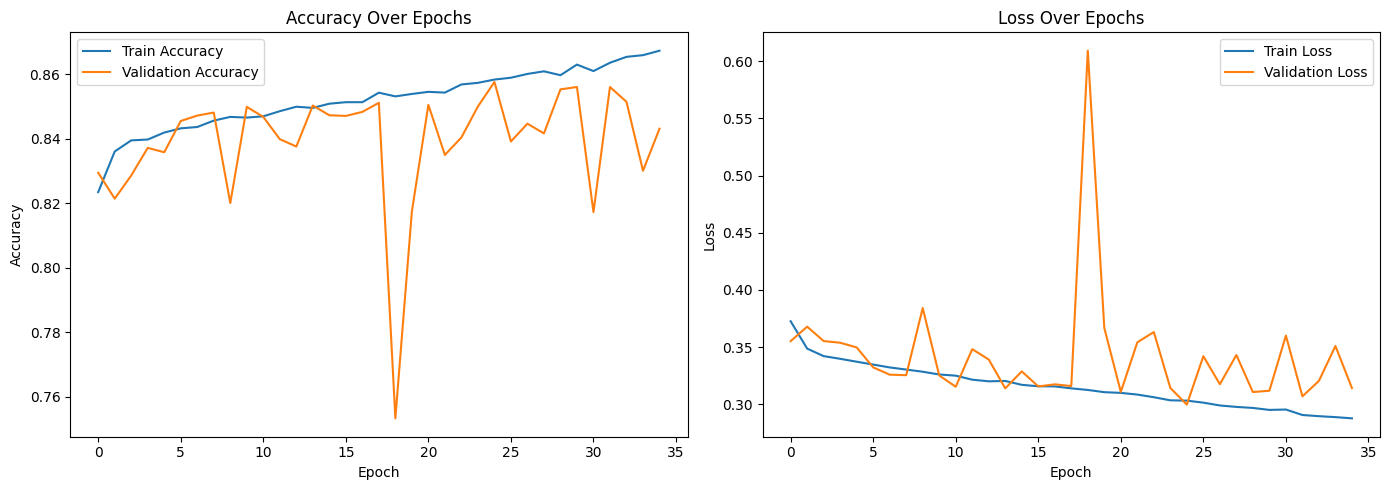

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

# def create_cnn_model(input_shape=(224, 224, 1)):
#     model = models.Sequential()

#     model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
#     model.add(layers.MaxPooling2D((2, 2)))

#     model.add(layers.Conv2D(64, (3, 3), activation='relu'))
#     model.add(layers.MaxPooling2D((2, 2)))

#     model.add(layers.Conv2D(128, (3, 3), activation='relu'))
#     model.add(layers.MaxPooling2D((2, 2)))

#     model.add(layers.Flatten())
#     model.add(layers.Dense(512, activation='relu'))
#     model.add(layers.Dropout(0.5))

#     model.add(layers.Dense(1, activation='sigmoid'))

#     model.compile(optimizer='adam',
#                   loss='binary_crossentropy',
#                   metrics=['accuracy'])# Binary classification
    

#     return model
# def create_cnn_model(input_shape=(224, 224, 1)):
#     model = models.Sequential()

#     model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
#     model.add(layers.BatchNormalization())
#     model.add(layers.MaxPooling2D((2, 2)))

#     model.add(layers.Conv2D(64, (3, 3), activation='relu'))
#     model.add(layers.BatchNormalization())
#     model.add(layers.MaxPooling2D((2, 2)))

#     model.add(layers.Conv2D(128, (3, 3), activation='relu'))
#     model.add(layers.BatchNormalization())
#     model.add(layers.MaxPooling2D((2, 2)))

#     model.add(layers.GlobalAveragePooling2D())

#     model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
#     model.add(layers.Dropout(0.5))

#     model.add(layers.Dense(1, activation='sigmoid'))

#     model.compile(optimizer='adam',
#                   loss='binary_crossentropy',
#                   metrics=['accuracy'])

#     return model
# 
from tensorflow.keras import layers, models, regularizers

def create_cnn_model(input_shape=(128, 128, 1)):
    model = models.Sequential()

    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model


model = create_cnn_model()
model.summary()

#80 20 split
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

df = pd.read_csv("groundtruth_with_augmented.csv")

#split 80-20
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["MEL"])
#new csvs
train_df.to_csv("train.csv", index=False)
test_df.to_csv("test.csv", index=False)

image_folder = "filtered_images"
def load_image(image_name, label):
    image_path = tf.strings.join([image_folder, '/', image_name])
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=1)  # Grayscale
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    return image, label
def create_tf_dataset(dataframe, batch_size=32, shuffle=True):
    image_names = dataframe['image'].values
    labels = dataframe['MEL'].values
    dataset = tf.data.Dataset.from_tensor_slices((image_names, labels))
    dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)
    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
train_dataset = create_tf_dataset(train_df)
test_dataset = create_tf_dataset(test_df, shuffle=False)

#training
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
early_stop = EarlyStopping(
    monitor='val_loss',     
    patience=10,             
    restore_best_weights=True 
)
checkpoint = ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=50, #try 75 then 50-100 next
    callbacks=[early_stop, checkpoint]
)

#plot training data
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Plot Accuracy
axs[0].plot(history.history['accuracy'], label='Train Accuracy')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_title("Accuracy Over Epochs")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy")
axs[0].legend()

# Plot Loss
axs[1].plot(history.history['loss'], label='Train Loss')
axs[1].plot(history.history['val_loss'], label='Validation Loss')
axs[1].set_title("Loss Over Epochs")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].legend()
plt.tight_layout()
plt.show()


In [1]:
#TEsting code
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model

test_df = pd.read_csv("test.csv")
image_folder = "filtered_images"

def load_image(image_name, label):
    image_path = tf.strings.join([image_folder, '/', image_name])
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=1)
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

def create_tf_dataset(dataframe, batch_size=32):
    image_names = dataframe['image'].values
    labels = dataframe['MEL'].values
    dataset = tf.data.Dataset.from_tensor_slices((image_names, labels))
    dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_dataset = create_tf_dataset(test_df)

model = load_model("best_model.h5")

loss, accuracy = model.evaluate(test_dataset)
print(f" Test Accuracy: {accuracy:.4f}")
print(f" Test Loss: {loss:.4f}")


300/300 ━━━━━━━━━━━━━━━━━━━━ 94s 310ms/step - accuracy: 0.8582 - loss: 0.2965
 Test Accuracy: 0.8576
 Test Loss: 0.2998
